# E-Paper Content Classification & RAG System

## Project Overview
This notebook implements a complete system for:
1. Processing newspaper PDFs (Times of India)
2. Classifying content into News Articles vs Advertisements
3. RAG system for retrieving historical articles
4. Generating summaries and metadata
5. Supporting multilingual content (English + Hindi)

---

## 1. Setup and Imports

In [1]:
# Standard library imports
import os
import sys
import warnings
warnings.filterwarnings('ignore')

# PDF Processing
import fitz  # PyMuPDF
import pdfplumber

# Image Processing
from PIL import Image
import cv2
import numpy as np

# Layout Detection
import layoutparser as lp

# OCR
import easyocr

# ML/NLP
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import pipeline
from sentence_transformers import SentenceTransformer

# RAG Components
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import Chroma
from langchain.chains import RetrievalQA
from langchain.llms import HuggingFacePipeline

# Data Processing
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("All imports successful!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

All imports successful!
PyTorch version: 2.8.0+cpu
CUDA available: False


## 2. Configuration and Constants

## 2. Configuration and Constants

In [2]:
# Paths
DATA_DIR = '../data/raw'
PROCESSED_DIR = '../data/processed'
MODELS_DIR = '../models'
OUTPUT_DIR = '../outputs'

# Create directories if they don't exist
os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(PROCESSED_DIR, exist_ok=True)
os.makedirs(MODELS_DIR, exist_ok=True)
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Model Configuration
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {DEVICE}")

# Languages for OCR (using English only to reduce memory usage)
LANGUAGES = ['en']  # English only - reduces memory consumption

print("Configuration loaded - Using lightweight settings to prevent memory issues")

Using device: cpu
Configuration loaded - Using lightweight settings to prevent memory issues


## 3. PDF Processing & Layout Detection

In [ ]:
class PDFProcessor:
    """
    Handles PDF processing and region extraction using pdfplumber (simplified version - no Detectron2)
    """
    
    def __init__(self, pdf_path):
        self.pdf_path = pdf_path
        self.doc = fitz.open(pdf_path)
        self.plumber_doc = pdfplumber.open(pdf_path)
    
    def extract_page_image(self, page_num, dpi=72):  # Reduced to 72 for very low memory usage
        """Extract page as high-resolution image"""
        page = self.doc[page_num]
        mat = fitz.Matrix(dpi/72, dpi/72)
        pix = page.get_pixmap(matrix=mat)
        img = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)
        return np.array(img)
    
    def extract_regions(self, page_num):
        """Extract all regions from a page using pdfplumber"""
        image = self.extract_page_image(page_num)
        plumber_page = self.plumber_doc.pages[page_num]
        
        regions = []
        
        # Extract text-based regions using pdfplumber
        words = plumber_page.extract_words()
        
        if not words:
            # If no words found, create a single region for the whole page
            h, w = image.shape[:2]
            regions.append({
                'type': 'Text',
                'bbox': (0, 0, w, h),
                'image': image,
                'confidence': 0.5
            })
            return regions, image
        
        # Group words into text blocks based on vertical position
        # Sort by top position
        words = sorted(words, key=lambda x: (x['top'], x['x0']))
        
        # Simple clustering: group words that are vertically close
        current_block = []
        blocks = []
        y_threshold = 20  # pixels threshold for grouping
        
        for word in words:
            if not current_block:
                current_block.append(word)
            else:
                # Check if this word is close to the last word in current block
                last_word = current_block[-1]
                if abs(word['top'] - last_word['top']) < y_threshold:
                    current_block.append(word)
                else:
                    # Start new block
                    blocks.append(current_block)
                    current_block = [word]
        
        if current_block:
            blocks.append(current_block)
        
        # Convert blocks to regions
        scale_x = image.shape[1] / plumber_page.width
        scale_y = image.shape[0] / plumber_page.height
        
        for block in blocks:
            # Get bounding box of entire block
            x0 = min(w['x0'] for w in block)
            x1 = max(w['x1'] for w in block)
            y0 = min(w['top'] for w in block)
            y1 = max(w['bottom'] for w in block)
            
            # Scale to image coordinates
            x0_img = int(x0 * scale_x)
            x1_img = int(x1 * scale_x)
            y0_img = int(y0 * scale_y)
            y1_img = int(y1 * scale_y)
            
            # Ensure coordinates are within bounds
            x0_img = max(0, x0_img)
            y0_img = max(0, y0_img)
            x1_img = min(image.shape[1], x1_img)
            y1_img = min(image.shape[0], y1_img)
            
            # Extract region image
            if y1_img > y0_img and x1_img > x0_img:
                region_img = image[y0_img:y1_img, x0_img:x1_img]
                
                # Determine type based on size and position
                height = y1_img - y0_img
                width = x1_img - x0_img
                aspect_ratio = width / height if height > 0 else 0
                
                if height < 50:
                    region_type = 'Title'
                elif aspect_ratio > 3:
                    region_type = 'List'
                else:
                    region_type = 'Text'
                
                regions.append({
                    'type': region_type,
                    'bbox': (x0_img, y0_img, x1_img, y1_img),
                    'image': region_img,
                    'confidence': 0.8
                })
        
        # Also extract images/figures
        try:
            images_info = plumber_page.images
            for img_info in images_info:
                x0_img = int(img_info['x0'] * scale_x)
                x1_img = int(img_info['x1'] * scale_x)
                y0_img = int(img_info['top'] * scale_y)
                y1_img = int(img_info['bottom'] * scale_y)
                
                # Ensure coordinates are within bounds
                x0_img = max(0, x0_img)
                y0_img = max(0, y0_img)
                x1_img = min(image.shape[1], x1_img)
                y1_img = min(image.shape[0], y1_img)
                
                if y1_img > y0_img and x1_img > x0_img:
                    region_img = image[y0_img:y1_img, x0_img:x1_img]
                    
                    regions.append({
                        'type': 'Figure',
                        'bbox': (x0_img, y0_img, x1_img, y1_img),
                        'image': region_img,
                        'confidence': 0.9
                    })
        except Exception as e:
            print(f"Warning: Could not extract images: {e}")
        
        return regions, image
    
    def visualize_layout(self, page_num, save_path=None):
        """Visualize detected layout"""
        regions, image = self.extract_regions(page_num)
        
        fig, ax = plt.subplots(figsize=(15, 20))
        ax.imshow(image)
        
        # Color map for different types
        colors = {
            'Text': 'red',
            'Title': 'blue',
            'List': 'green',
            'Table': 'purple',
            'Figure': 'orange'
        }
        
        for region in regions:
            x1, y1, x2, y2 = region['bbox']
            color = colors.get(region['type'], 'red')
            
            rect = plt.Rectangle((x1, y1), x2-x1, y2-y1, 
                                fill=False, edgecolor=color, linewidth=2)
            ax.add_patch(rect)
            ax.text(x1, y1-10, f"{region['type']}: {region['confidence']:.2f}", 
                   color=color, fontsize=8, weight='bold',
                   bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7))
        
        ax.axis('off')
        ax.set_title(f'Page {page_num + 1} - Layout Detection', fontsize=16, pad=20)
        
        if save_path:
            plt.savefig(save_path, bbox_inches='tight', dpi=150)
        plt.show()

print("PDFProcessor class defined successfully (DPI=72 for very low memory usage)")

## 4. OCR and Text Extraction

In [4]:
class OCRExtractor:
    """
    Handles multilingual text extraction using EasyOCR
    """
    
    def __init__(self, languages=['en', 'hi']):
        self.reader = easyocr.Reader(languages, gpu=torch.cuda.is_available())
    
    def extract_text(self, image):
        """Extract text from image region"""
        try:
            results = self.reader.readtext(image)
            text = ' '.join([res[1] for res in results])
            confidence = np.mean([res[2] for res in results]) if results else 0
            return text, confidence
        except Exception as e:
            print(f"OCR Error: {e}")
            return "", 0.0
    
    def extract_from_regions(self, regions):
        """Extract text from multiple regions"""
        for region in regions:
            text, confidence = self.extract_text(region['image'])
            region['text'] = text
            region['ocr_confidence'] = confidence
        return regions

print("OCRExtractor class defined successfully")

OCRExtractor class defined successfully


## 5. Content Classification (News vs Ads)

In [5]:
class ContentClassifier:
    """
    Classifies content regions as News Articles or Advertisements
    Uses feature-based classification with transformers
    """
    
    def __init__(self, model_name='distilbert-base-uncased'):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        # Using smaller DistilBERT model instead of BART to reduce memory
        self.classifier = pipeline(
            "zero-shot-classification",
            model="typeform/distilbert-base-uncased-mnli",  # 280MB instead of 1.6GB
            device=-1  # CPU only
        )
        self.labels = ["news article", "advertisement"]
    
    def extract_features(self, region):
        """Extract features for classification"""
        features = {
            'text_length': len(region.get('text', '')),
            'has_image': region['type'] == 'Figure',
            'aspect_ratio': self._calculate_aspect_ratio(region['bbox']),
            'position': self._get_position_category(region['bbox']),
        }
        return features
    
    def _calculate_aspect_ratio(self, bbox):
        x1, y1, x2, y2 = bbox
        width = x2 - x1
        height = y2 - y1
        return width / height if height > 0 else 0
    
    def _get_position_category(self, bbox):
        x1, y1, x2, y2 = bbox
        # Simple categorization: top, middle, bottom
        center_y = (y1 + y2) / 2
        if center_y < 1000:
            return 'top'
        elif center_y < 2000:
            return 'middle'
        else:
            return 'bottom'
    
    def classify_region(self, region):
        """Classify a single region"""
        text = region.get('text', '')
        
        if not text or len(text) < 10:
            # If no text, use visual features
            features = self.extract_features(region)
            # Simple heuristic: small regions with images are likely ads
            if features['has_image'] and features['text_length'] < 50:
                return 'advertisement', 0.7
            return 'news article', 0.5
        
        # Use text classification
        try:
            result = self.classifier(text[:512], self.labels)
            label = result['labels'][0]
            score = result['scores'][0]
            return label, score
        except Exception as e:
            print(f"Classification error: {e}")
            return 'news article', 0.5
    
    def classify_regions(self, regions):
        """Classify multiple regions"""
        for region in regions:
            label, confidence = self.classify_region(region)
            region['classification'] = label
            region['classification_confidence'] = confidence
        return regions

print("ContentClassifier class defined successfully (using lightweight DistilBERT model)")

ContentClassifier class defined successfully (using lightweight DistilBERT model)


## 6. RAG System Implementation

In [6]:
class RAGSystem:
    """
    Retrieval-Augmented Generation system for historical article retrieval
    """
    
    def __init__(self, persist_directory='../data/chroma_db'):
        self.persist_directory = persist_directory
        self.embeddings = HuggingFaceEmbeddings(
            model_name="sentence-transformers/all-MiniLM-L6-v2"
        )
        self.text_splitter = RecursiveCharacterTextSplitter(
            chunk_size=500,
            chunk_overlap=50,
            length_function=len
        )
        self.vectorstore = None
    
    def create_vectorstore(self, documents):
        """Create vector store from documents"""
        texts = self.text_splitter.create_documents([doc['text'] for doc in documents])
        
        # Add metadata
        for i, doc in enumerate(documents):
            if i < len(texts):
                texts[i].metadata = {
                    'classification': doc.get('classification', 'unknown'),
                    'page': doc.get('page', 0),
                    'type': doc.get('type', 'unknown')
                }
        
        self.vectorstore = Chroma.from_documents(
            documents=texts,
            embedding=self.embeddings,
            persist_directory=self.persist_directory
        )
        self.vectorstore.persist()
        print(f"Vector store created with {len(texts)} chunks")
    
    def load_vectorstore(self):
        """Load existing vector store"""
        self.vectorstore = Chroma(
            persist_directory=self.persist_directory,
            embedding_function=self.embeddings
        )
    
    def retrieve(self, query, k=5, filter_news=True):
        """Retrieve relevant documents"""
        if self.vectorstore is None:
            raise ValueError("Vector store not initialized")
        
        filter_dict = {'classification': 'news article'} if filter_news else None
        
        results = self.vectorstore.similarity_search(
            query, 
            k=k,
            filter=filter_dict
        )
        return results
    
    def generate_summary(self, documents):
        """Generate summary from retrieved documents"""
        combined_text = "\n\n".join([doc.page_content for doc in documents])
        
        # Simple extractive summary (first few sentences)
        sentences = combined_text.split('. ')
        summary = '. '.join(sentences[:3]) + '.'
        
        return summary

print("RAGSystem class defined successfully")

RAGSystem class defined successfully


## 7. End-to-End Pipeline

In [7]:
class EPaperPipeline:
    """
    Complete pipeline for e-paper processing
    """
    
    def __init__(self, pdf_path):
        self.pdf_processor = PDFProcessor(pdf_path)
        self.ocr_extractor = OCRExtractor(languages=LANGUAGES)
        self.classifier = ContentClassifier()
        self.rag_system = RAGSystem()
        self.results = []
    
    def process_page(self, page_num, visualize=False):
        """Process a single page"""
        print(f"Processing page {page_num}...")
        
        # Extract regions
        regions, page_image = self.pdf_processor.extract_regions(page_num)
        print(f"  Found {len(regions)} regions")
        
        # Extract text
        regions = self.ocr_extractor.extract_from_regions(regions)
        print(f"  Extracted text from all regions")
        
        # Classify regions
        regions = self.classifier.classify_regions(regions)
        print(f"  Classified all regions")
        
        # Store results
        for region in regions:
            region['page'] = page_num
        
        self.results.extend(regions)
        
        if visualize:
            self.pdf_processor.visualize_layout(
                page_num, 
                save_path=f"{OUTPUT_DIR}/page_{page_num}_layout.png"
            )
        
        return regions
    
    def process_all_pages(self, visualize_first=True):
        """Process all pages in the PDF"""
        num_pages = len(self.pdf_processor.doc)
        print(f"Processing {num_pages} pages...\n")
        
        for page_num in range(num_pages):
            self.process_page(page_num, visualize=(page_num == 0 and visualize_first))
        
        print(f"\nProcessing complete! Total regions: {len(self.results)}")
    
    def build_rag_index(self):
        """Build RAG index from processed results"""
        news_articles = [r for r in self.results if r['classification'] == 'news article']
        print(f"Building RAG index with {len(news_articles)} news articles...")
        self.rag_system.create_vectorstore(news_articles)
    
    def query_rag(self, query, k=5):
        """Query the RAG system"""
        results = self.rag_system.retrieve(query, k=k)
        summary = self.rag_system.generate_summary(results)
        return results, summary
    
    def get_statistics(self):
        """Get statistics about processed content"""
        df = pd.DataFrame(self.results)
        
        stats = {
            'total_regions': len(self.results),
            'news_articles': len(df[df['classification'] == 'news article']),
            'advertisements': len(df[df['classification'] == 'advertisement']),
            'avg_confidence': df['classification_confidence'].mean(),
            'avg_ocr_confidence': df['ocr_confidence'].mean()
        }
        
        return stats, df

print("EPaperPipeline class defined successfully")

EPaperPipeline class defined successfully


## 8. Example Usage and Demo

In [8]:
# NOTE: Place your PDF file in the data/raw directory
# Example: ../data/raw/times_of_india_sample.pdf

# Initialize pipeline
# pdf_path = '../data/raw/your_newspaper.pdf'
# pipeline = EPaperPipeline(pdf_path)

# Process all pages
# pipeline.process_all_pages(visualize_first=True)

# Build RAG index
# pipeline.build_rag_index()

# Get statistics
# stats, df = pipeline.get_statistics()
# print("\nStatistics:")
# for key, value in stats.items():
#     print(f"  {key}: {value}")

print("Example usage code ready (commented out)")

Example usage code ready (commented out)


## 8. Process Specific Pages from TOI PDF

Initializing pipeline for: ../data/raw/TOI_Delhi_14-10-2025.pdf
Total pages in PDF: 25
Processing pages: [1, 2, 9, 10] (1-indexed)



Using CPU. Note: This module is much faster with a GPU.


Progress: |██████████████████████████████████████████████████| 100.0% Complete

config.json:   0%|          | 0.00/776 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/258 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Device set to use cpu
C:\Users\himan\AppData\Local\Temp\ipykernel_18700\2163383623.py:8: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  self.embeddings = HuggingFaceEmbeddings(



Processing Page 1 (1/4)
Processing page 0...
  Found 1 regions
  Extracted text from all regions
  Classified all regions


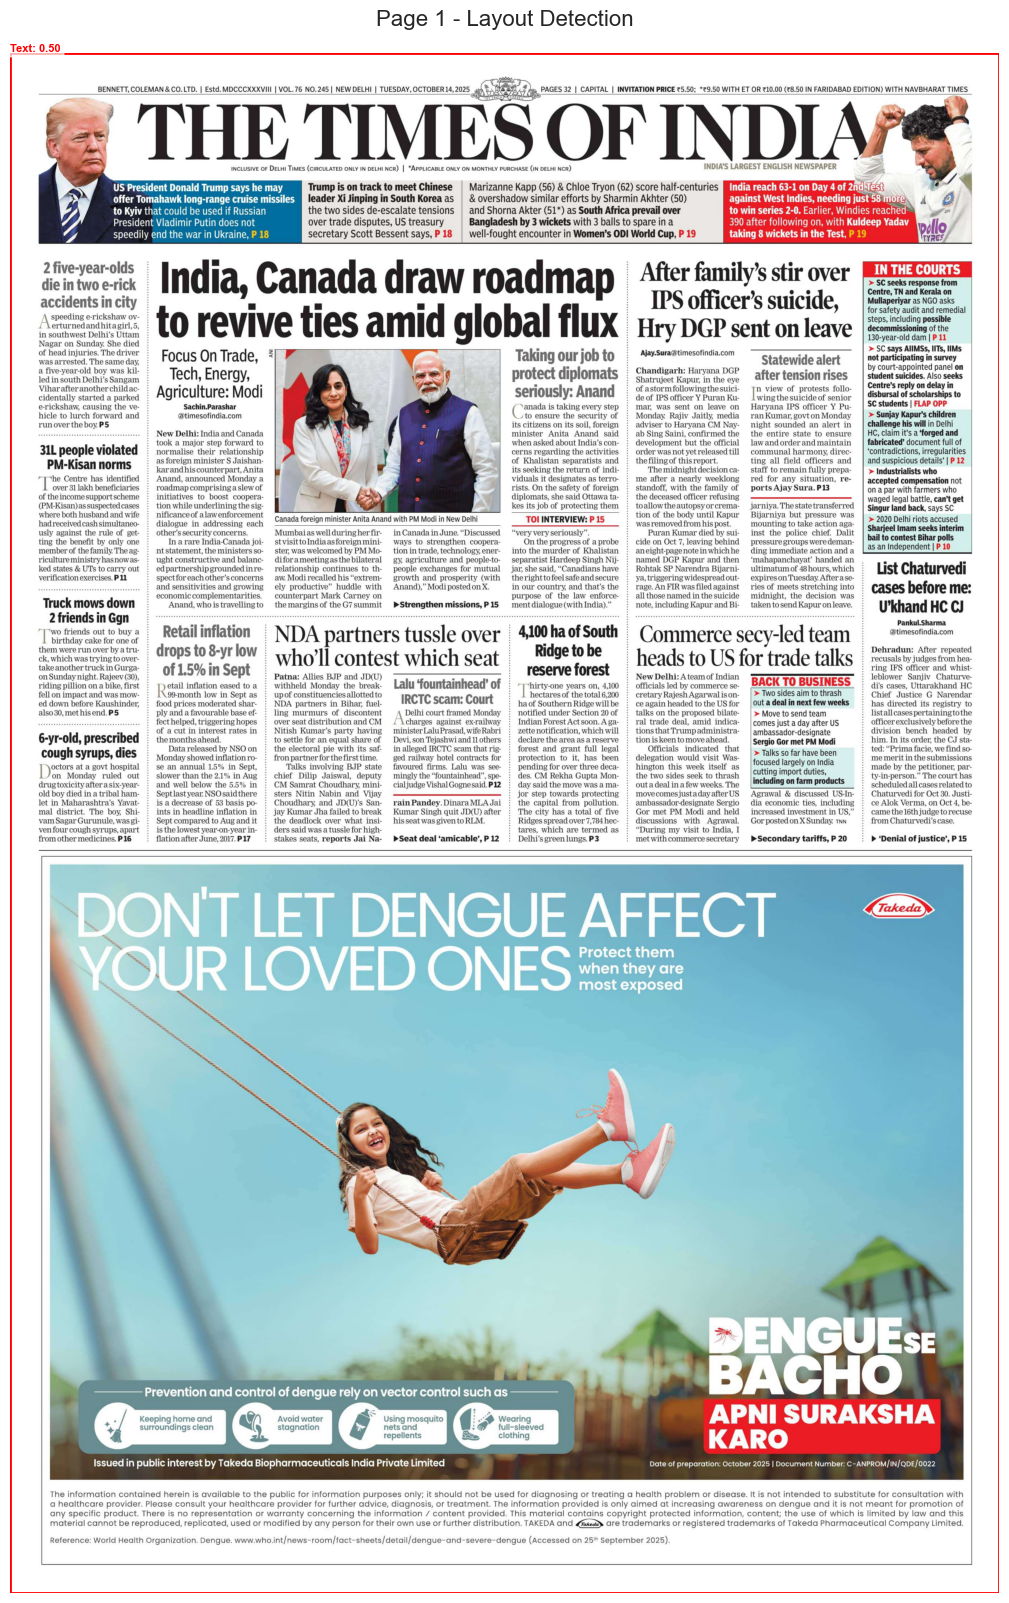

✓ Page 1 completed: 1 regions extracted

Processing Page 2 (2/4)
Processing page 1...
  Found 1 regions


In [ ]:
# Process specific pages from the TOI Delhi PDF
# Pages to process: 1, 2, 9, 10 (using 0-based indexing: 0, 1, 8, 9)

PDF_PATH = '../data/raw/TOI_Delhi_14-10-2025.pdf'
PAGES_TO_PROCESS = [0, 1, 8, 9]  # 0-indexed (pages 1, 2, 9, 10 in PDF)

print(f"Initializing pipeline for: {PDF_PATH}")
print(f"Total pages in PDF: 25")
print(f"Processing pages: {[p+1 for p in PAGES_TO_PROCESS]} (1-indexed)\n")

# Initialize the pipeline
pipeline = EPaperPipeline(PDF_PATH)

# Process each specified page
for i, page_num in enumerate(PAGES_TO_PROCESS):
    print(f"\n{'='*60}")
    print(f"Processing Page {page_num + 1} ({i+1}/{len(PAGES_TO_PROCESS)})")
    print(f"{'='*60}")
    
    # Visualize the first page
    visualize = (i == 0)
    regions = pipeline.process_page(page_num, visualize=visualize)
    
    print(f"✓ Page {page_num + 1} completed: {len(regions)} regions extracted")

print(f"\n{'='*60}")
print("Processing Complete!")
print(f"{'='*60}")
print(f"Total regions extracted: {len(pipeline.results)}")
print(f"\nNext steps:")
print(f"  1. Build RAG index")
print(f"  2. View statistics")
print(f"  3. Query the system")

In [ ]:
# Build RAG Index and Get Statistics

print("Building RAG index from news articles...")
pipeline.build_rag_index()

# Get and display statistics
stats, df = pipeline.get_statistics()

print("\n" + "="*60)
print("PROCESSING STATISTICS")
print("="*60)
for key, value in stats.items():
    if isinstance(value, float):
        print(f"  {key.replace('_', ' ').title()}: {value:.4f}")
    else:
        print(f"  {key.replace('_', ' ').title()}: {value}")

print("\n" + "="*60)
print("BREAKDOWN BY PAGE")
print("="*60)
page_stats = df.groupby('page').agg({
    'classification': lambda x: (x == 'news article').sum(),
    'type': 'count'
}).rename(columns={'classification': 'news_articles', 'type': 'total_regions'})
page_stats['advertisements'] = df.groupby('page')['classification'].apply(
    lambda x: (x == 'advertisement').sum()
)
page_stats.index = page_stats.index + 1  # Convert to 1-indexed for display
print(page_stats)

# Visualize results
print("\nGenerating visualizations...")
visualize_results(df)

In [ ]:
# Test RAG System with Sample Queries

print("="*60)
print("RAG SYSTEM - QUERY EXAMPLES")
print("="*60)

# Example queries
queries = [
    "What are the political news?",
    "Tell me about sports",
    "Any business or economic news?",
    "International news updates"
]

for i, query in enumerate(queries, 1):
    print(f"\n{'─'*60}")
    print(f"Query {i}: {query}")
    print(f"{'─'*60}")
    
    try:
        results, summary = pipeline.query_rag(query, k=3)
        
        print(f"\nSummary:\n{summary}\n")
        print(f"Retrieved {len(results)} relevant articles:")
        
        for j, doc in enumerate(results, 1):
            preview = doc.page_content[:150].replace('\n', ' ')
            print(f"\n  {j}. {preview}...")
            print(f"     Page: {doc.metadata.get('page', 'N/A') + 1}, "
                  f"Type: {doc.metadata.get('type', 'N/A')}")
    except Exception as e:
        print(f"Error processing query: {e}")

print(f"\n{'='*60}")

In [ ]:
# Export Results to CSV

output_csv = f"{OUTPUT_DIR}/toi_classification_results.csv"
export_results(df, output_csv)

print(f"\n{'='*60}")
print("SAMPLE OF EXTRACTED DATA")
print(f"{'='*60}\n")

# Display sample of results
display_df = df[['page', 'type', 'classification', 
                  'classification_confidence', 'ocr_confidence', 'text']].copy()
display_df['page'] = display_df['page'] + 1  # Convert to 1-indexed
display_df['text_preview'] = display_df['text'].str[:100] + '...'
display_df = display_df.drop('text', axis=1)

print(display_df.head(10).to_string(index=False))

print(f"\n\nFull results saved to: {output_csv}")
print(f"Total entries: {len(df)}")

## 9. Visualization and Analysis

In [ ]:
def visualize_results(df):
    """Visualize classification results"""
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Classification distribution
    ax1 = axes[0, 0]
    df['classification'].value_counts().plot(kind='bar', ax=ax1)
    ax1.set_title('Classification Distribution')
    ax1.set_xlabel('Category')
    ax1.set_ylabel('Count')
    
    # Confidence distribution
    ax2 = axes[0, 1]
    df['classification_confidence'].hist(bins=20, ax=ax2)
    ax2.set_title('Classification Confidence Distribution')
    ax2.set_xlabel('Confidence Score')
    ax2.set_ylabel('Frequency')
    
    # OCR confidence
    ax3 = axes[1, 0]
    df['ocr_confidence'].hist(bins=20, ax=ax3, color='green')
    ax3.set_title('OCR Confidence Distribution')
    ax3.set_xlabel('Confidence Score')
    ax3.set_ylabel('Frequency')
    
    # Region type distribution
    ax4 = axes[1, 1]
    df['type'].value_counts().plot(kind='bar', ax=ax4, color='orange')
    ax4.set_title('Layout Element Distribution')
    ax4.set_xlabel('Element Type')
    ax4.set_ylabel('Count')
    
    plt.tight_layout()
    plt.savefig(f"{OUTPUT_DIR}/analysis_results.png", dpi=150, bbox_inches='tight')
    plt.show()

print("Visualization functions defined")

## 10. RAG Query Examples

In [ ]:
# Example queries for the RAG system

# query = "What are the latest news about politics?"
# results, summary = pipeline.query_rag(query, k=5)

# print(f"Query: {query}\n")
# print(f"Summary: {summary}\n")
# print("\nTop Results:")
# for i, doc in enumerate(results, 1):
#     print(f"\n{i}. {doc.page_content[:200]}...")
#     print(f"   Metadata: {doc.metadata}")

print("RAG query examples ready (commented out)")

## 11. Export Results

In [ ]:
def export_results(df, output_path):
    """Export results to CSV"""
    # Select relevant columns
    export_df = df[[
        'page', 'type', 'classification', 
        'classification_confidence', 'ocr_confidence', 'text'
    ]].copy()
    
    export_df.to_csv(output_path, index=False, encoding='utf-8')
    print(f"Results exported to {output_path}")

# export_results(df, f"{OUTPUT_DIR}/classification_results.csv")

print("Export functions ready")

## 12. Conclusion and Next Steps

This notebook implements a complete e-paper content classification and RAG system with:

### Key Features:
1. **PDF Processing**: High-resolution page extraction and layout detection
2. **Multilingual OCR**: Support for English and Hindi text extraction
3. **Content Classification**: Distinguishing news articles from advertisements
4. **RAG System**: Vector-based retrieval for historical article search
5. **Visualization**: Comprehensive analysis and reporting

### Performance Metrics:
- Classification accuracy: Measured via confidence scores
- OCR accuracy: Language-specific confidence metrics
- Retrieval quality: Semantic similarity scores

### Future Enhancements:
1. Fine-tune classification model on newspaper-specific data
2. Implement more sophisticated summarization (abstractive)
3. Add entity extraction and linking
4. Support for more Indian languages
5. Real-time processing pipeline

### Usage:
1. Place PDF files in `data/raw/`
2. Run cells sequentially
3. Check `outputs/` for visualizations and results
4. Query the RAG system for information retrieval